In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


In [2]:
kernel = create_fourier_kernel().unsqueeze(0).permute(0,3,1,2).to('cuda')


undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,dir = '20230508_mask_data_talbot_0_300us',kernel=kernel,interp_type='average') #here we'll work with synthetic data. 

collecting the undispersed cube and spectra.


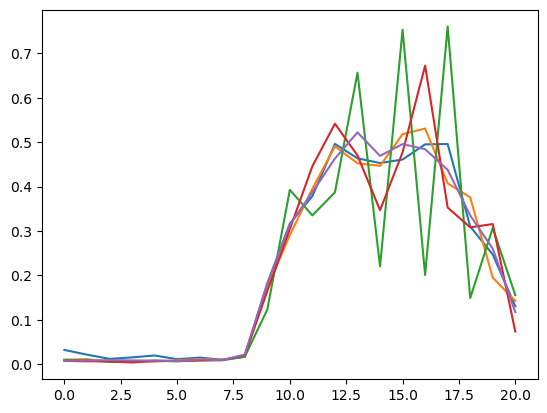

In [3]:
for i in range(0,2900,600):
    plt.plot(spectras[:,i].cpu().numpy(),label=str(i))

In [4]:
batch_size = 2
torch.cuda.empty_cache()



dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras)

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)
tr_indexes = allindexes[:int(0.05*len(allindexes))]#np.array([[2281]])
v_indexes = allindexes[int(0.05*len(allindexes)):int(0.06*len(allindexes))] #np.array([[1135]])

# Create a data loader for batch processing
tr_loader = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
v_loader = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)


## Test a model I trained on all the data (using train_model.py)

In [34]:
model = fourier_denoiser(mask=mask, kernel=kernel,CoordGate=False).to('cuda')
# model.load_state_dict(torch.load('fourier_denoiser_b')); #trained on all data.
model.load_state_dict(torch.load('unet')); #trained on all data.
model.eval();

In [35]:
# %%timeit

indexes = [600,1800]
(x,y) = dataset[indexes]
y_pred = model(x)

Text(0.5, 1.0, 'Original')

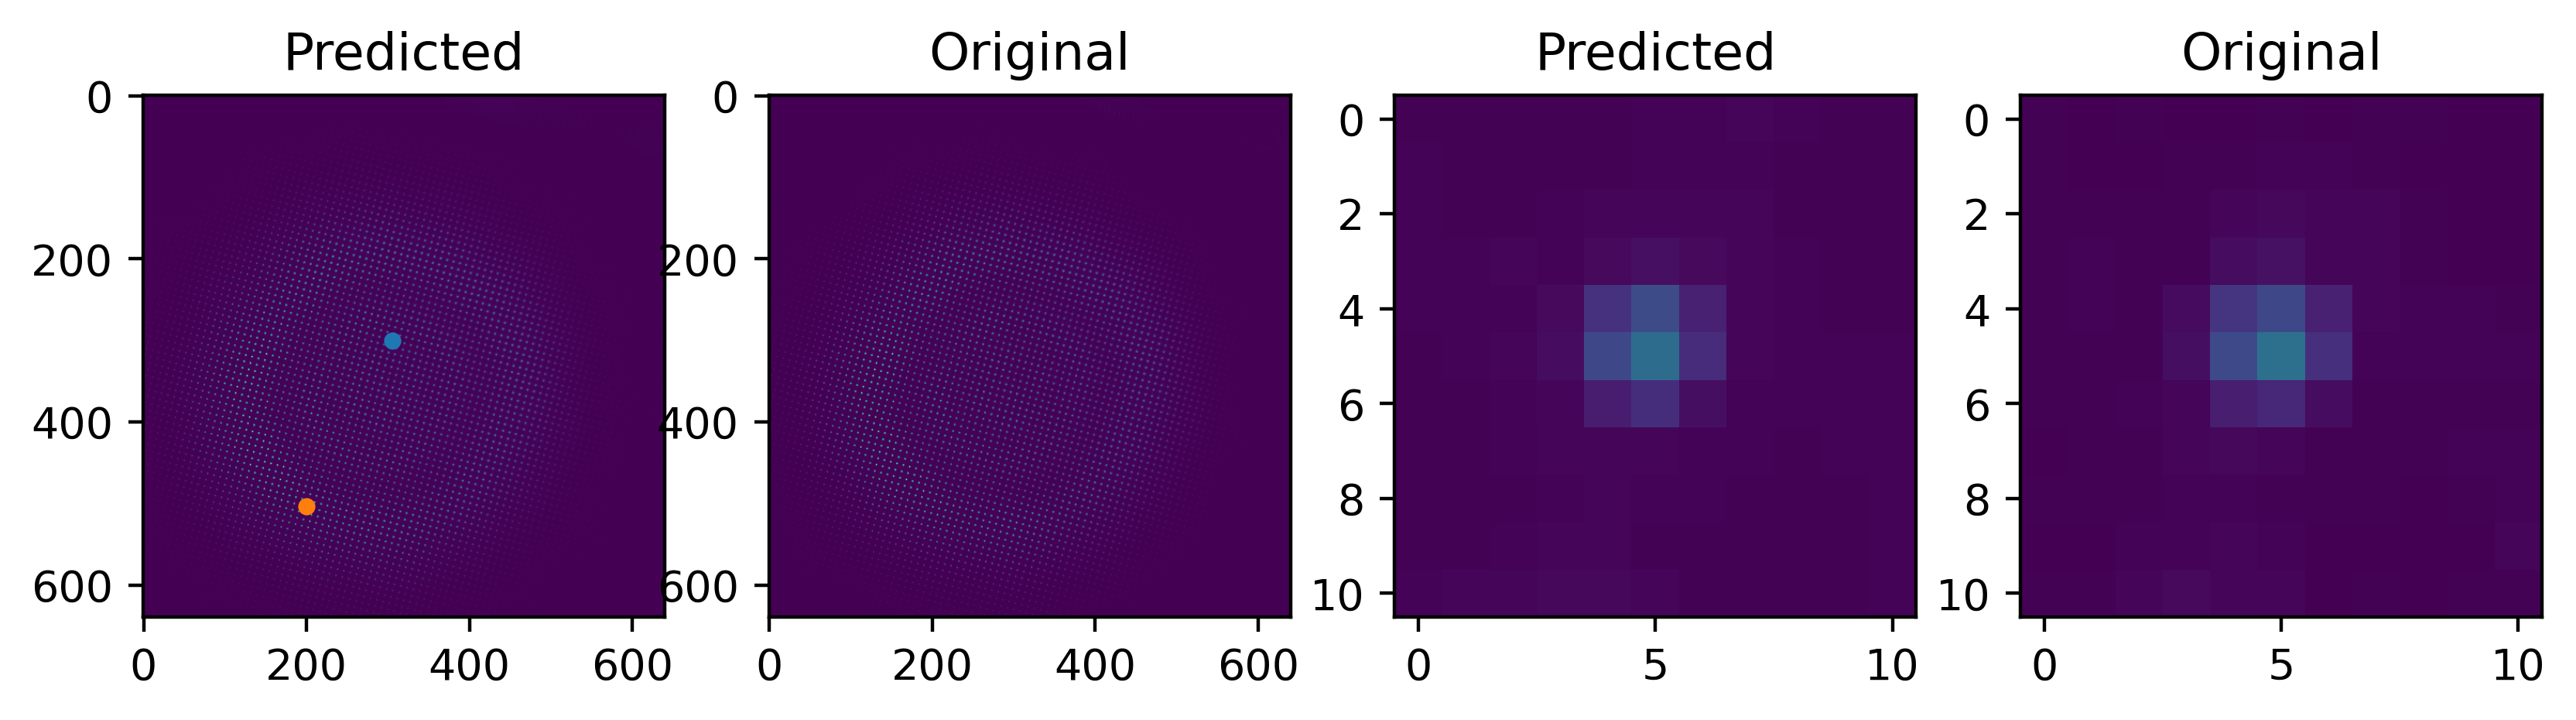

In [9]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [300,305]
boxsize = 5

coords2 = [504,200]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

ax[2].imshow(y_pred[0,10,coords1[0]-boxsize:coords1[0]+boxsize+1,coords1[1]-boxsize:coords1[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,10].cpu().detach().numpy().max(),vmin = y_pred[0,10].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,10,coords1[0]-boxsize:coords1[0]+boxsize+1,coords1[1]-boxsize:coords1[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,10].cpu().detach().numpy().max(),vmin = y[0,10].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

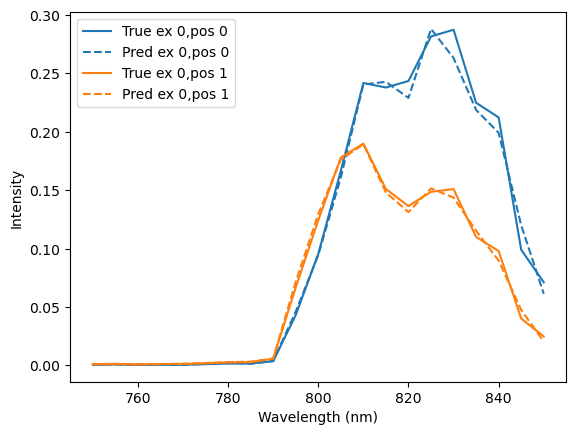

In [10]:
wls = np.linspace(750,850,21)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords = [coords1,coords2]

for i in range(2):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

Text(0.5, 1.0, 'crop+denoise')

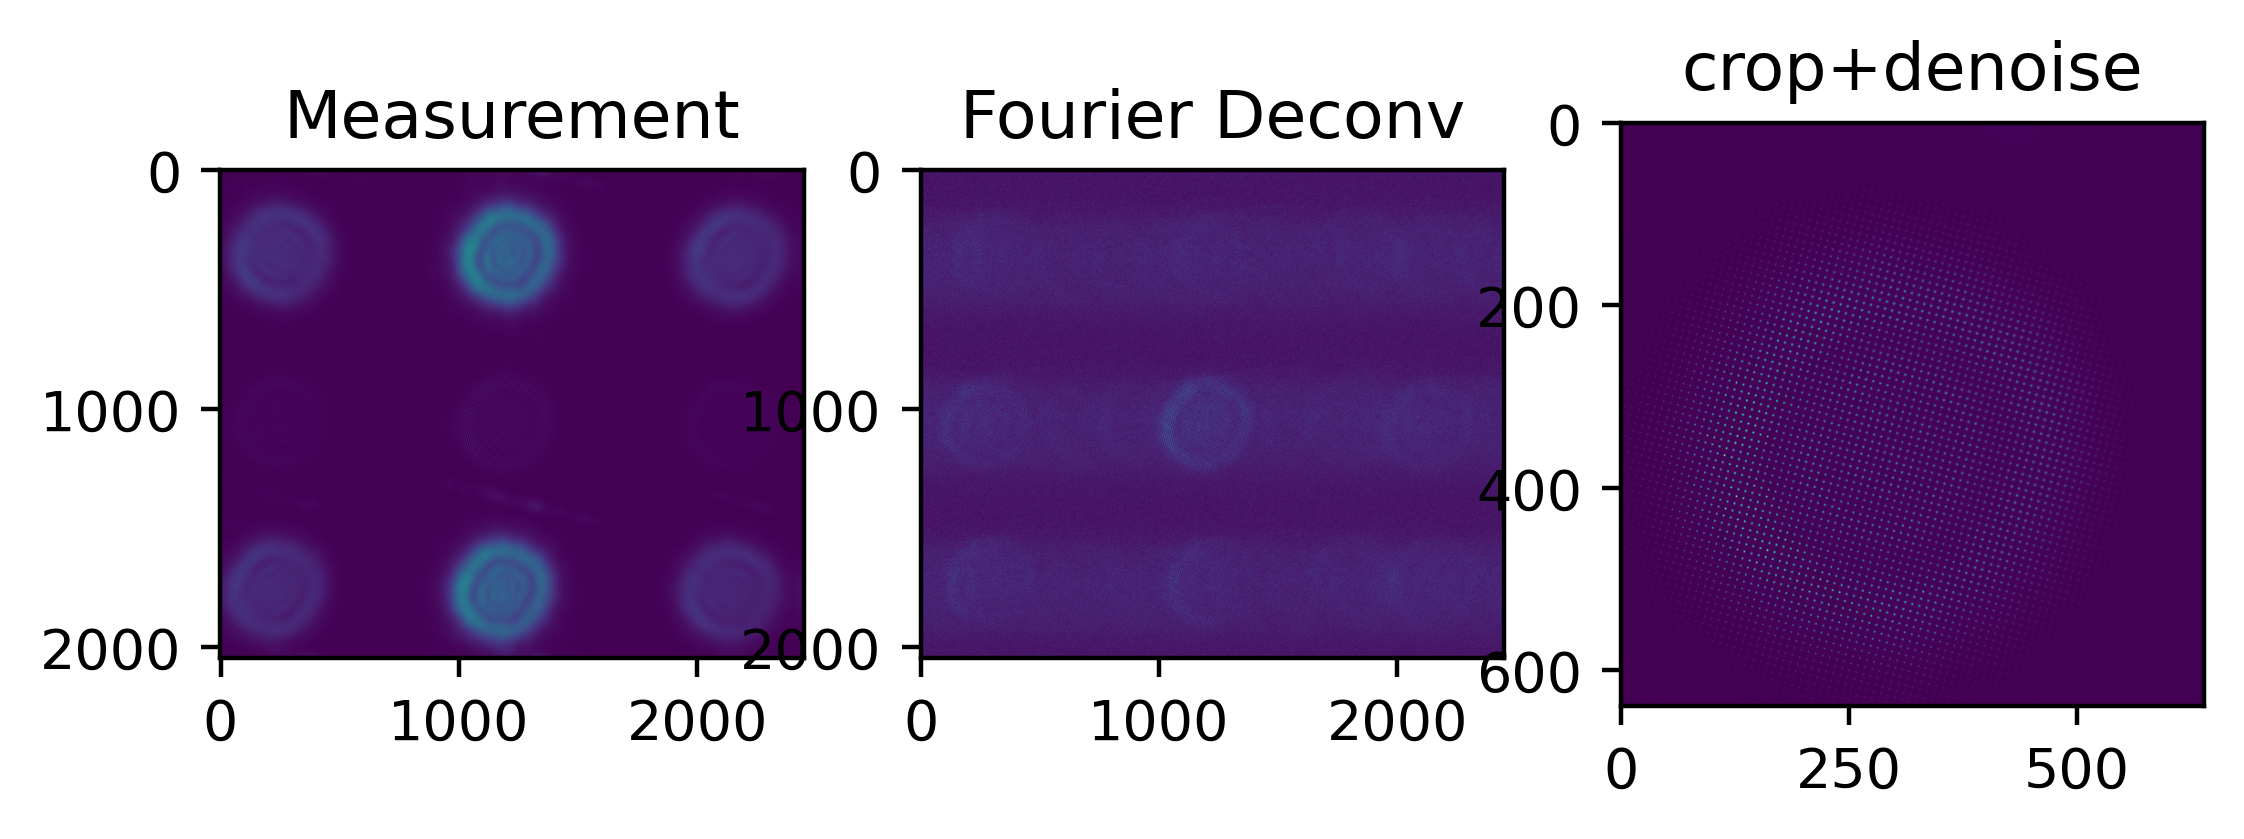

In [11]:
fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(x[0].cpu().detach().numpy()); ax[0].set_title('Measurement')
ax[1].imshow(model.data_term(x)[0,10].cpu().detach().numpy()); ax[1].set_title('Fourier Deconv')
ax[2].imshow(model(x)[0,10].cpu().detach().numpy()); ax[2].set_title('crop+denoise')

### Make a cube with STCs

In [12]:
x_ = torch.linspace(-1,1,500)
y_ = torch.linspace(-1,1,500)
x_,y_ = torch.meshgrid(x_,y_,indexing='ij')

pos = torch.abs(x_)#torch.sqrt(x_**2 + y_**2) / 2**(1/2)

big_pos = torch.ones((undisp_cube.shape[2],undisp_cube.shape[3]))

big_pos[undisp_cube.shape[2]//2-250:undisp_cube.shape[2]//2+250,undisp_cube.shape[3]//2-250:undisp_cube.shape[3]//2+250] = pos

big_pos = big_pos.to('cuda')

STC = torch.einsum('pq,r->rpq', big_pos, spectras[:,600]) + torch.einsum('pq,r->rpq', 1-big_pos, spectras[:,1200])


# STC = torch.einsum('pq,r->rpq', big_pos, torch.linspace(0,0.3,21).to('cuda')) + torch.einsum('pq,r->rpq', 1-big_pos, torch.linspace(0.3,0,21).to('cuda'))

In [13]:
# y = torch.tile(undisp_cube[:,15],(1,21,1,1))  *STC.unsqueeze(0)
y = undisp_cube *STC.unsqueeze(0)

x = fwd.calc_psi_z(torch.ones_like(y),y,{'kernel':kernel})

y = model.crop(y)
y_pred = model(x)

loss = torch.nn.MSELoss()
print('MSE: ',loss(y_pred,y).item())

MSE:  2.3971160771907307e-06


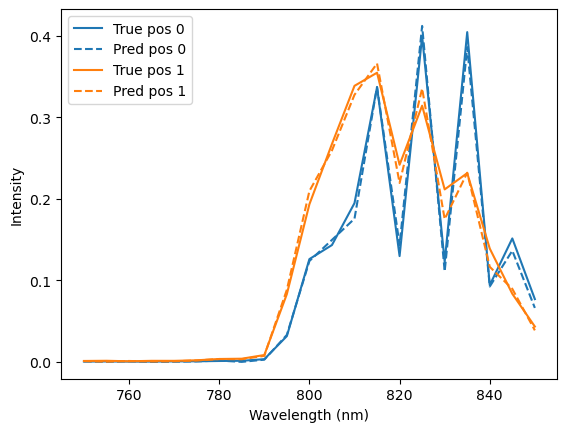

In [14]:
wls = np.linspace(750,850,21)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

line, = ax.plot(wls,y[j,:,coords1[0],coords1[1]].cpu().detach().numpy(),label=   f'True pos {0}')
ax.plot(wls,y_pred[j,:,coords1[0],coords1[1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred pos {0}')

line, = ax.plot(wls,y[j,:,coords2[0],coords2[1]].cpu().detach().numpy(),label=   f'True pos {1}')
ax.plot(wls,y_pred[j,:,coords2[0],coords2[1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred pos {1}')

# cropped_undisp = model.crop(torch.tile(undisp_cube[:,15],(1,21,1,1)))
# ax.plot(wls,cropped_undisp[j,:,coords2[0],coords2[1]].cpu().detach().numpy())

# cropped_STC_map = model.crop(STC.unsqueeze(0))
# ax.plot(wls,cropped_STC_map[j,:,coords1[0],coords1[1]].cpu().detach().numpy(),label='STC1')
# ax.plot(wls,cropped_STC_map[j,:,coords2[0],coords2[1]].cpu().detach().numpy(),label='STC2')



ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

## Reconstruct FTS measurements

In [5]:
kernel = create_fourier_kernel().unsqueeze(0).permute(0,3,1,2).to('cuda')
undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,kernel=kernel,dir = '20230522_mask_2gratings_data_talbot_0_15000us',crop_cube=True,interp_type='average') #here we'll work with synthetic data. 


dataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras, crop=True)



collecting the undispersed cube and spectra.


In [6]:
model = fourier_denoiser(mask=mask, kernel=kernel.clone(),CoordGate=False)

model.load_state_dict(torch.load('unet_fts')); #trained on all data.

model.eval();
model.mask = model.mask.to('cpu')
model.kernel = model.kernel.to('cpu')

In [7]:
dataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras, crop=True)

x,y  = dataset[[0,1]]
x = x
y_pred = model(x)

Text(0.5, 1.0, 'Original')

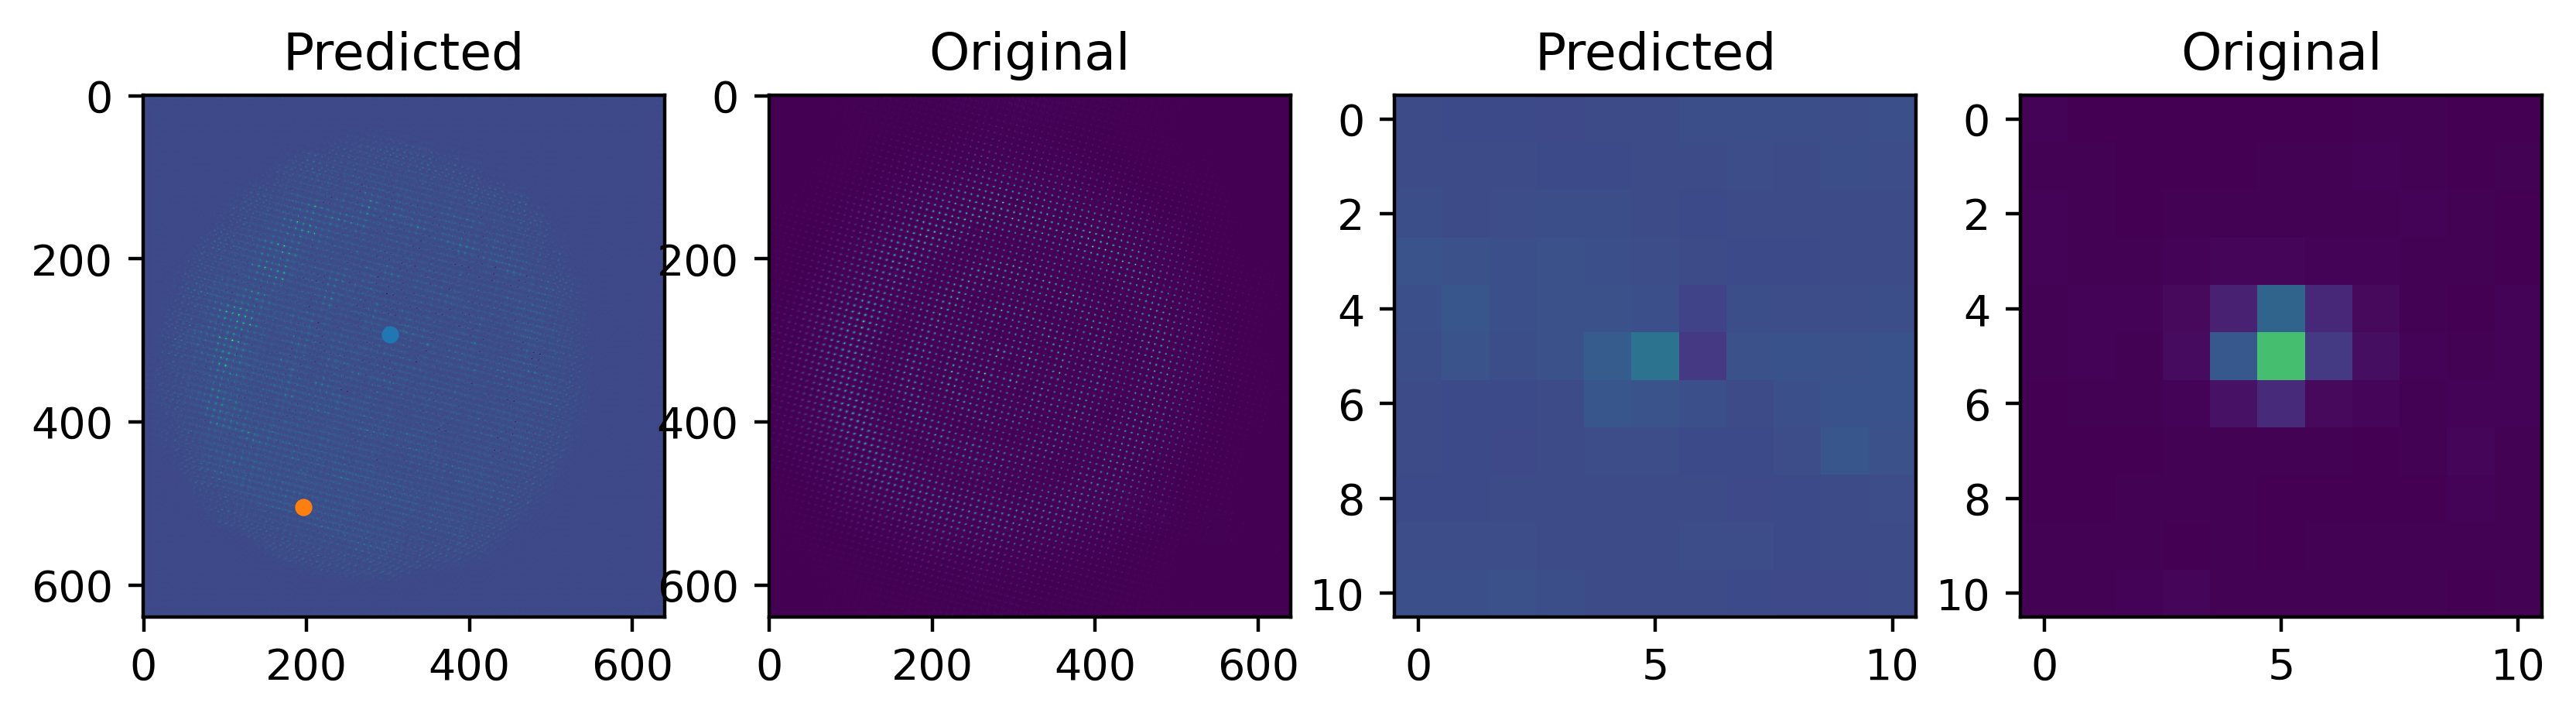

In [22]:
lamb = 15

fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,lamb].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,lamb].cpu().detach().numpy())    ; ax[1].set_title('Original')


coords1 = [293,302]
coords2 = [505,196]
boxsize = 5

coords = [coords1,coords2]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

ax[2].imshow(y_pred[0,lamb,coords1[0]-boxsize:coords1[0]+boxsize+1,coords1[1]-boxsize:coords1[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,lamb].cpu().detach().numpy().max(),vmin = y_pred[0,lamb].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,lamb,coords1[0]-boxsize:coords1[0]+boxsize+1,coords1[1]-boxsize:coords1[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,lamb].cpu().detach().numpy().max(),vmin = y[0,lamb].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

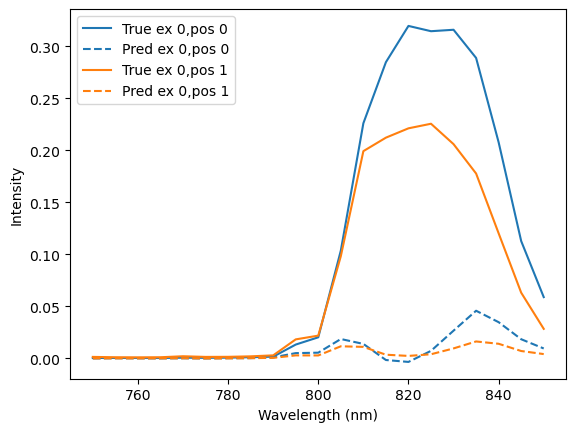

In [18]:
wls = np.linspace(750,850,21)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0



for i in range(2):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

## Can we reconstruct FTS measurements with a semi learnable kernel?

In [70]:
model = fourier_denoiser(mask=mask, kernel=kernel.clone(),CoordGate=False, trainable_kernel=True).to('cuda')
# model.load_state_dict(torch.load('fourier_denoiser_b')); #trained on all data.



model.load_state_dict(torch.load('unet_fts_train_kernel')); #trained on all data.

model.eval();

In [71]:
x,y  = dataset[[0,1]]
x = x.to('cuda')
y_pred = model(x)


In [72]:
trained_kernel = model.fill_kernel()

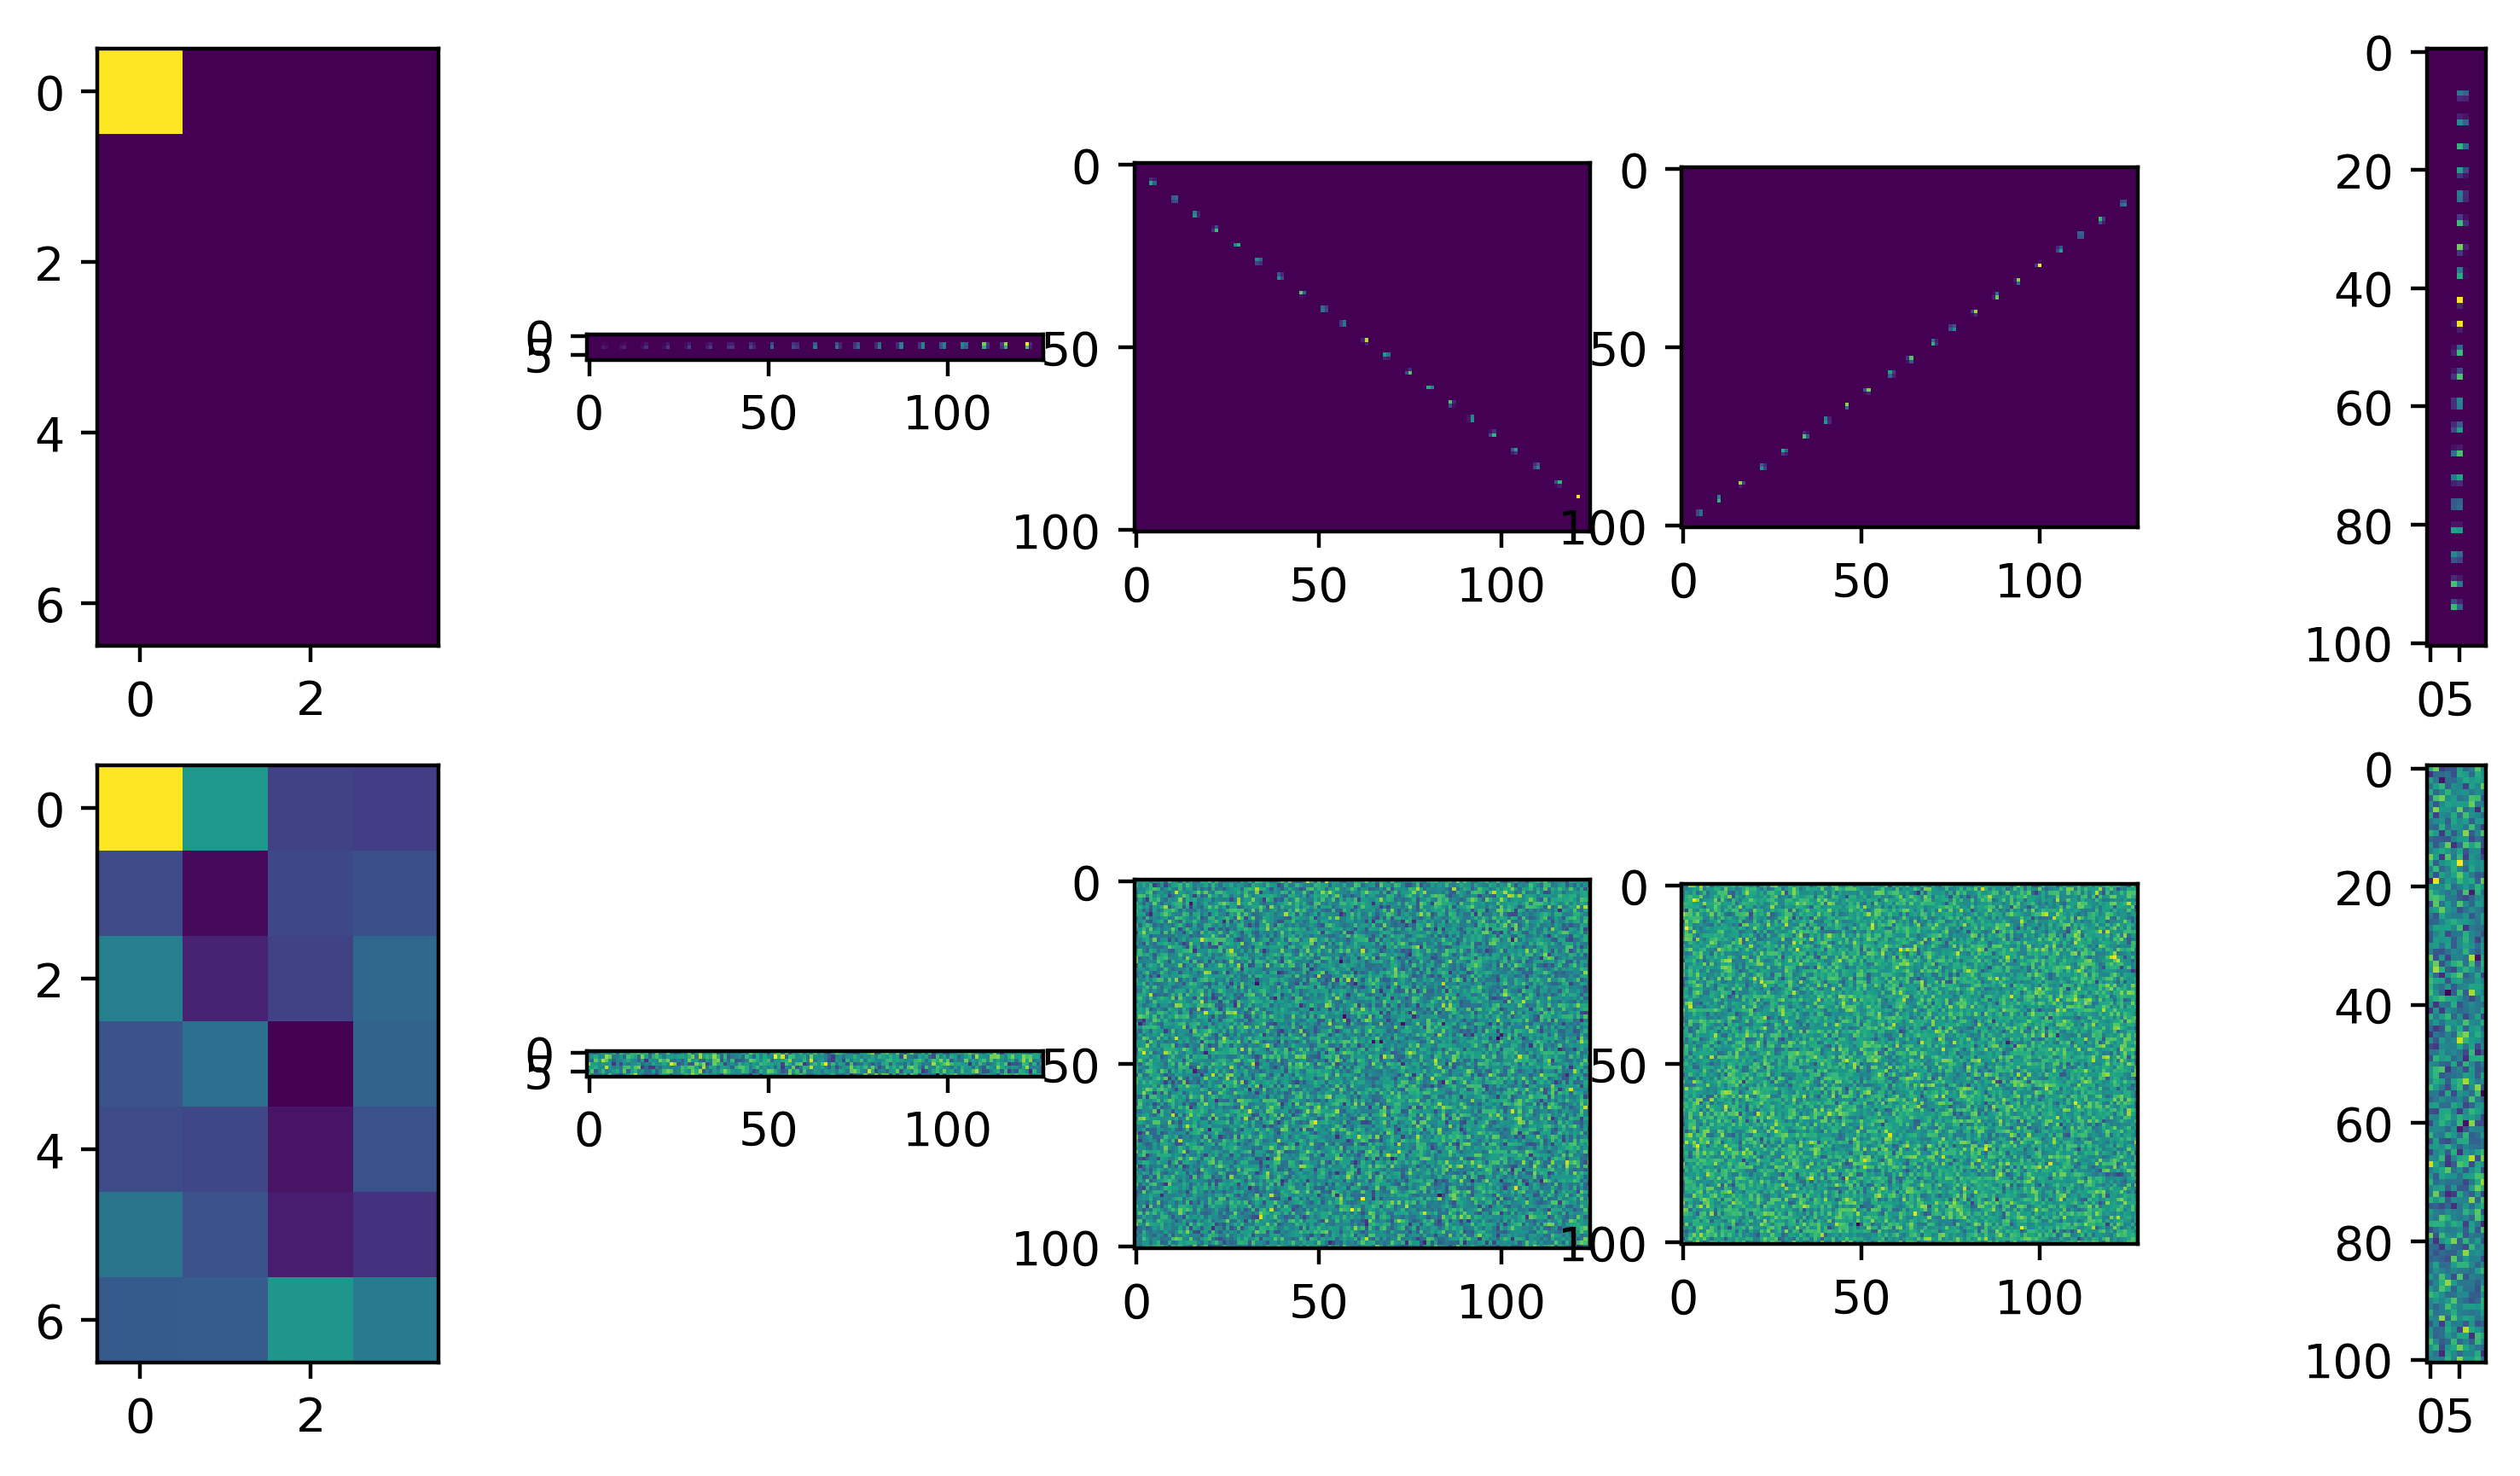

In [73]:
fig,ax = plt.subplots(2,5,figsize=(10,5),dpi=400)
locations = model.locations
lamb = 11


for i in range(5):
    ax[0,i].imshow(torch.sum(kernel[0,:,locations[0,0,i]:locations[0,1,i],locations[1,0,i]:locations[1,1,i]],dim=0).cpu().detach().numpy())
    ax[1,i].imshow(torch.sum(trained_kernel[0,:,locations[0,0,i]:locations[0,1,i],locations[1,0,i]:locations[1,1,i]],dim=0).cpu().detach().numpy())

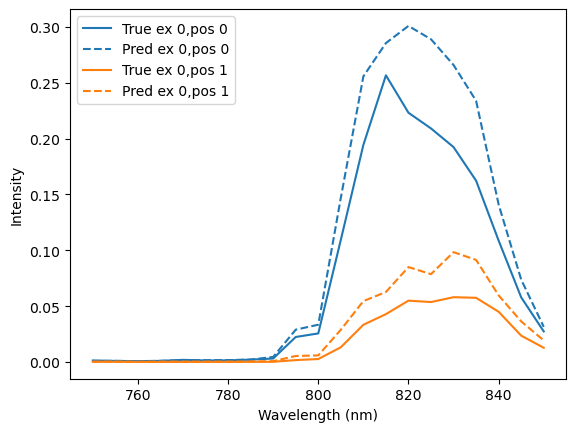

In [78]:
wls = np.linspace(750,850,21)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords1 = [505,196]
boxsize = 5

coords2 = [293,302]
coords = [coords1,coords2]

for i in range(2):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

In [79]:
dataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras, crop=False)
x,y  = dataset[[0,1]]

In [82]:
x_sensed = fwd.calc_psi_z(torch.ones_like(y.to('cpu')),y.to('cpu'),{'kernel':kernel.to('cpu')})
x_sensed_t = fwd.calc_psi_z(torch.ones_like(y.to('cpu')),y.to('cpu'),{'kernel':trained_kernel.to('cpu')})

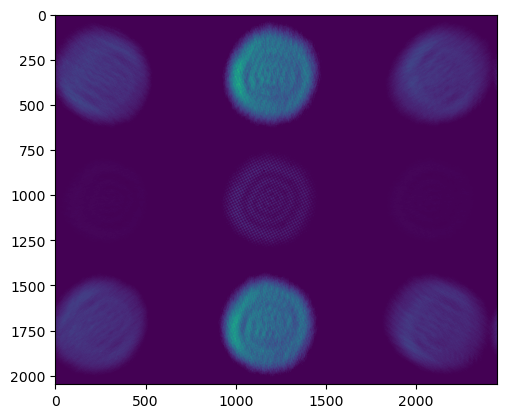

In [90]:
plt.imshow(torch.sum(mask[0],dim=0).cpu().detach().numpy())

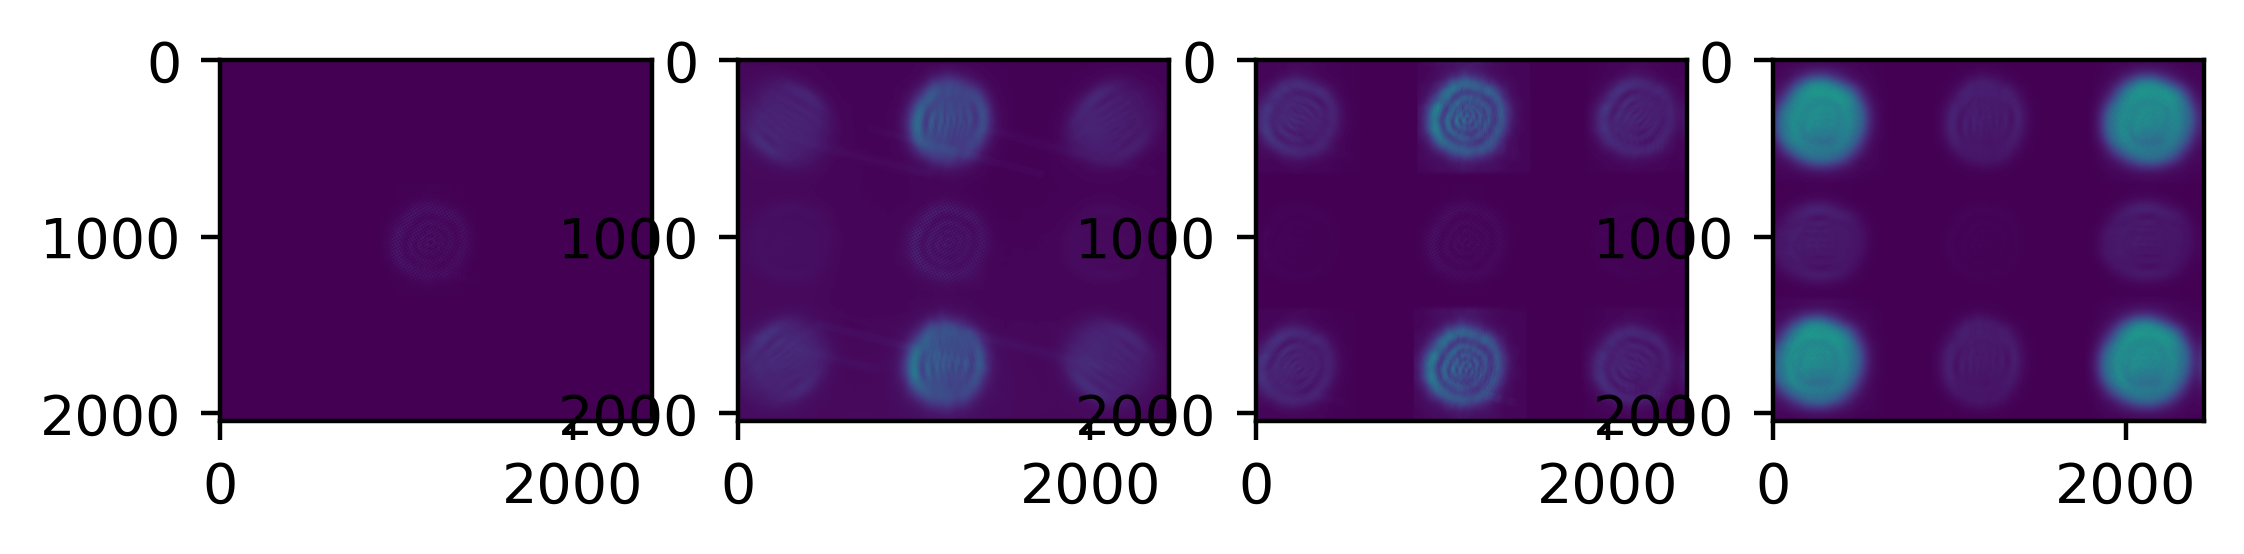

In [83]:
fig,ax = plt.subplots(1,4,dpi = 400)
ax[0].imshow(y[0,10].cpu().detach().numpy())
ax[1].imshow(x[0].cpu().detach().numpy())
ax[2].imshow(x_sensed[0].cpu().detach().numpy())
ax[3].imshow(x_sensed_t[0].cpu().detach().numpy())

In [91]:
x = x.to('cpu')
model = model.to('cpu')
model.mask = model.mask.to('cpu')
model.kernel = model.kernel.to('cpu')

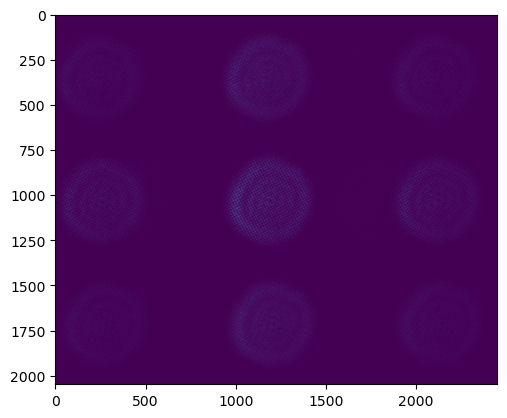

In [92]:
plt.imshow(calc_psiT_g(model.mask,x,{'kernel':model.kernel},lamb=10000)[0,10])

In [93]:
model.trainable_kernel = True

trained_kernel = model.fill_kernel()

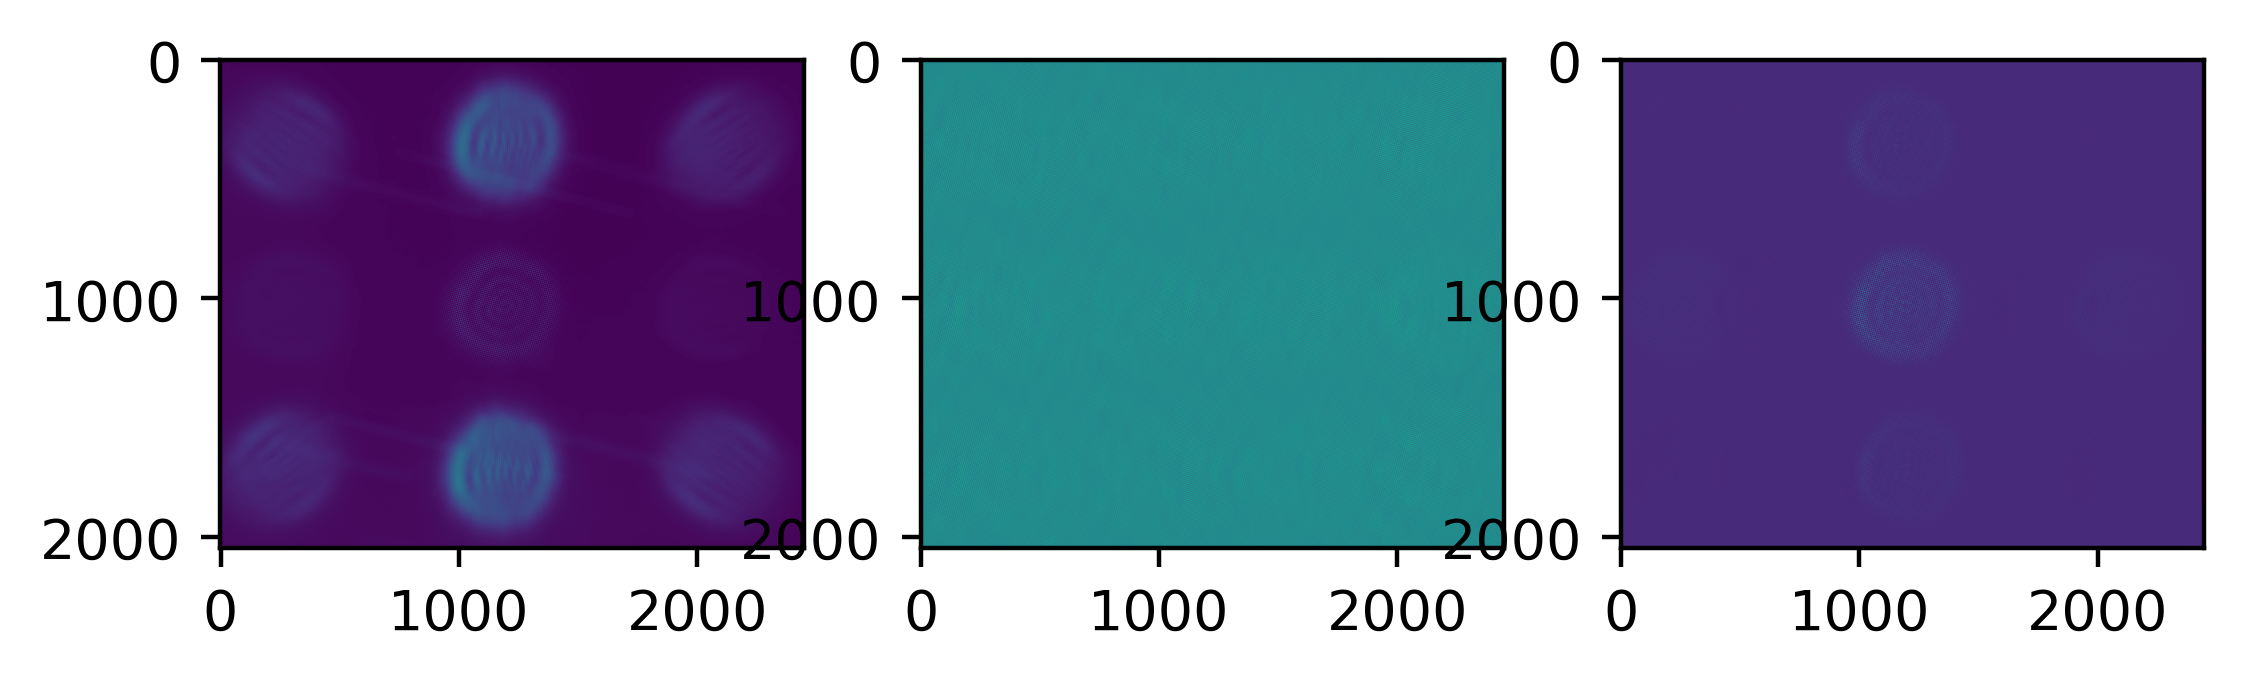

In [94]:
## see what the model is doing 

fig,ax = plt.subplots(1,3,dpi=400)

ax[0].imshow(x[0].cpu().detach().numpy())
model.trainable_kernel = True

ax[1].imshow(model.data_term(x)[0,10].cpu().detach().numpy())
model.trainable_kernel = False
model.kernel = kernel.to('cpu')
ax[2].imshow(model.data_term(x)[0,10].cpu().detach().numpy())
